In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import librosa # pip install librosa==0.8.1
import librosa.display
import IPython.display as ipd

import tensorflow as tf
from tensorflow import keras

from pathlib import Path
from IPython.display import display, Audio

In [2]:
SAMPLING_RATE = 24000

In [3]:
SCALE = 0.5

BATCH_SIZE = 128
EPOCHS = 100

In [4]:
audios = pd.read_csv(r'C:\Users\stair\OneDrive\Documentos\speaker-recognition-dim0494\train.csv')

In [5]:
audios['speaker'].value_counts()

0     302
74    285
89    272
7     260
11    242
     ... 
49     27
73     25
42     24
41     16
53     16
Name: speaker, Length: 84, dtype: int64

C:\Users\stair\miniconda3\envs\dim0494\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


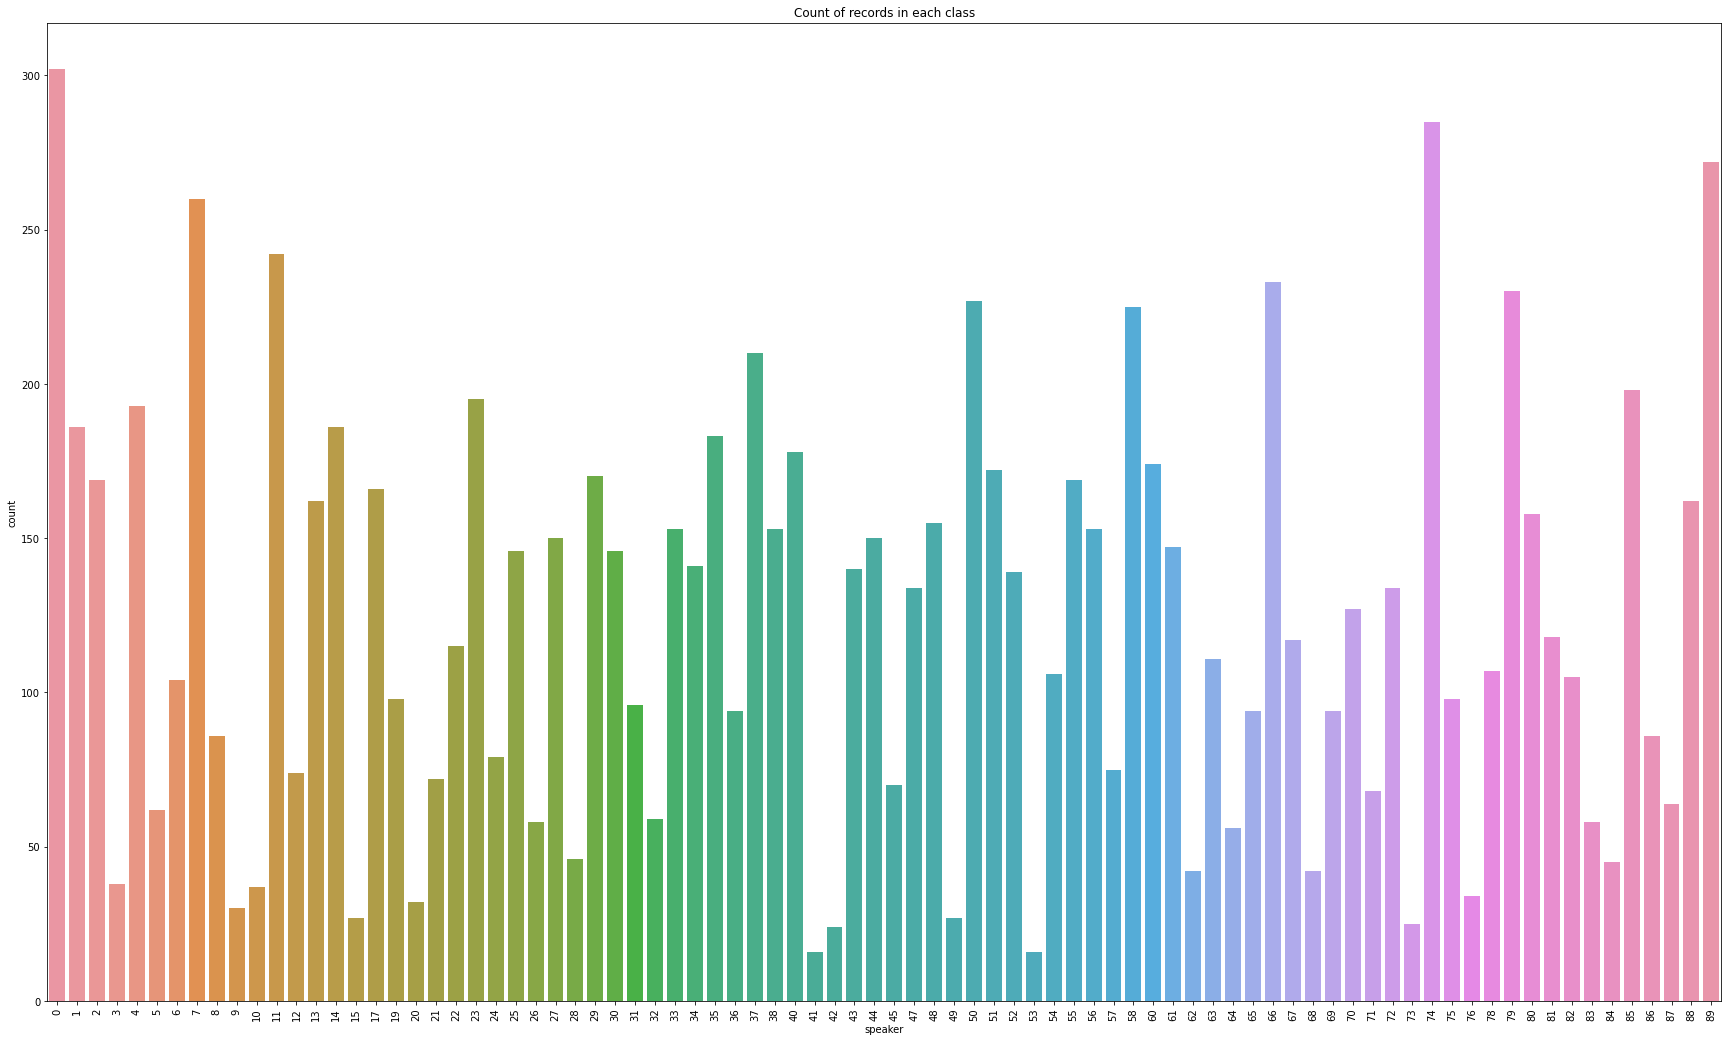

In [6]:
import seaborn as sns
plt.figure(figsize=(30, 18))
sns.countplot(audios['speaker'])
plt.title("Count of records in each class")
plt.xticks(rotation="vertical")
plt.show()

In [7]:
def features_extractor(file):
    #load the file (audio)
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    #we extract mfcc
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    #in order to find out scaled feature we do mean of transpose of value
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    return mfccs_scaled_features

In [8]:
#Now we ned to extract the featured from all the audio files so we use tqdm
import numpy as np
from tqdm import tqdm
### Now we iterate through every audio file and extract features 
### using Mel-Frequency Cepstral Coefficients
extracted_features=[]
for index_num,row in tqdm(audios.iterrows()):
    file_name = os.path.join(os.path.abspath(r'C:\Users\stair\OneDrive\Documentos\speaker-recognition-dim0494'),str(row["file_path"]))
    final_class_labels=row["speaker"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

10380it [06:04, 28.51it/s]


In [9]:
extracted_features_df=pd.DataFrame(extracted_features,columns=['file_path','speaker'])
extracted_features_df.head()

,file_path,speaker
0,"[-269.89566, 69.05291, -16.704552, 45.07816, 4...",35
1,"[-298.75436, 121.3749, 0.8947951, 41.216553, 7...",31
2,"[-277.81485, 82.95264, -34.886154, 29.067257, ...",79
3,"[-318.0133, 102.188614, -20.88142, 24.035286, ...",69
4,"[-268.33987, 79.32434, -21.487785, 30.396057, ...",34


In [10]:
### Split the dataset into independent and dependent dataset
X=np.array(extracted_features_df['file_path'].tolist())
y=np.array(extracted_features_df['speaker'].tolist())

### Label Encoding -> Label Encoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

### Train Test Split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
### No of classes
num_labels=y.shape[1]

In [12]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               4100      
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               20200     
                                                                 
 activation_1 (Activation)   (None, 200)               0         
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               2

In [14]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [15]:
## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 
num_epochs = 200
num_batch_size = 128
checkpointer = ModelCheckpoint(filepath='./audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()
history = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)
duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/200
55/65 [========================>.....] - ETA: 0s - loss: 19.0204 - accuracy: 0.0158
Epoch 1: val_loss improved from inf to 4.42171, saving model to .\audio_classification.hdf5
65/65 [==============================] - 1s 6ms/step - loss: 16.9458 - accuracy: 0.0157 - val_loss: 4.4217 - val_accuracy: 0.0193
Epoch 2/200
55/65 [========================>.....] - ETA: 0s - loss: 4.7449 - accuracy: 0.0189
Epoch 2: val_loss improved from 4.42171 to 4.40749, saving model to .\audio_classification.hdf5
65/65 [==============================] - 0s 4ms/step - loss: 4.7200 - accuracy: 0.0202 - val_loss: 4.4075 - val_accuracy: 0.0193
Epoch 3/200
56/65 [========================>.....] - ETA: 0s - loss: 4.5078 - accuracy: 0.0246
Epoch 3: val_loss improved from 4.40749 to 4.39391, saving model to .\audio_classification.hdf5
65/65 [==============================] - 0s 4ms/step - loss: 4.4997 - accuracy: 0.0247 - val_loss: 4.3939 - val_accuracy: 0.0193
Epoch 4/200
55/65 [=======================

In [16]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.8617533445358276


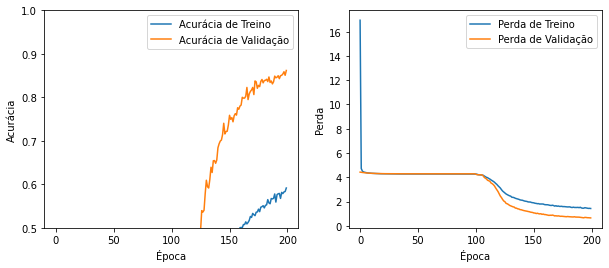

In [17]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Acurácia de Treino')
plt.plot(history.history['val_accuracy'], label = 'Acurácia de Validação')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.ylim([0.5, 1])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Perda de Treino')
plt.plot(history.history['val_loss'], label = 'Perda de Validação')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend(loc='upper right')

plt.show()

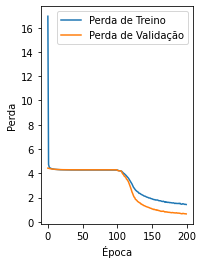

In [18]:
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Perda de Treino')
plt.plot(history.history['val_loss'], label = 'Perda de Validação')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend(loc='upper right')

plt.show()

In [19]:
#model.predict_classes(X_test)
predict_x=model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)
print(classes_x)

65/65 [==============================] - 0s 797us/step
[16 24 62 ... 28 34 51]


In [22]:
filename=r"C:\Users\stair\OneDrive\Documentos\speaker-recognition-dim0494\test\87_121553_000024_000000.wav"
#preprocess the audio file
audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
#Reshape MFCC feature to 2-D array
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
#predicted_label=model.predict_classes(mfccs_scaled_features)
x_predict=model.predict(mfccs_scaled_features) 
predicted_label=np.argmax(x_predict,axis=1)
#print(predicted_label)
prediction_class = labelencoder.inverse_transform(predicted_label) 
print(prediction_class)

1/1 [==============================] - 0s 16ms/step
[67]
